In [1]:
import os
import scipy.signal as sp
%matplotlib inline
# import nbimporter
import sys  

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

import importlib
importlib.reload(gp) 
importlib.reload(sdc) 

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


/Users/xiaowenyuan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Calibration Data

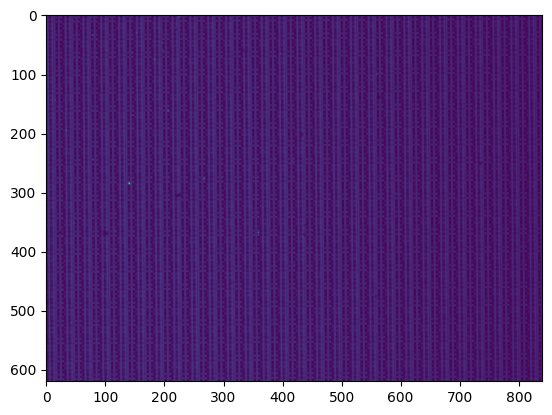

Shape of the tensor: torch.Size([620, 840, 45])


In [2]:
# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
summed_filtered_array = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)

# Normalize the filter array to the maximum value
filter_array_normalized = summed_filtered_array / np.amax(summed_filtered_array)

# Convert the normalized filter array to a PyTorch tensor
filter_array_normalized_tensor = torch.tensor(filter_array_normalized)

# Extract dimensions of the tensor
dim0, dim1, dim2 = filter_array_normalized_tensor.shape

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(filter_array_normalized_tensor, axis=2))
# plt.colorbar()  # Uncomment to display the color bar
plt.show()

# Print the shape of the tensor
print("Shape of the tensor:", filter_array_normalized_tensor.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = filter_array_normalized_tensor.shape

/var/folders/28/3cj3m_9j28z7nvy5l5vw45rm0000gn/T/ipykernel_32141/3807443899.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))


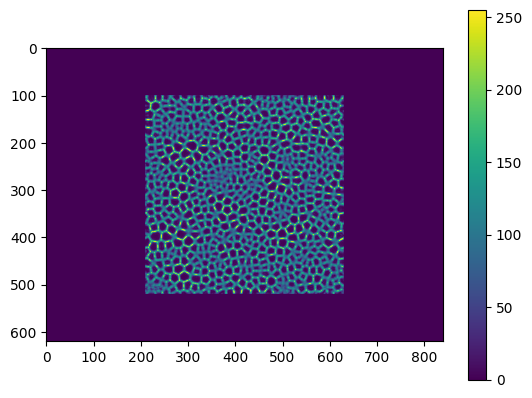

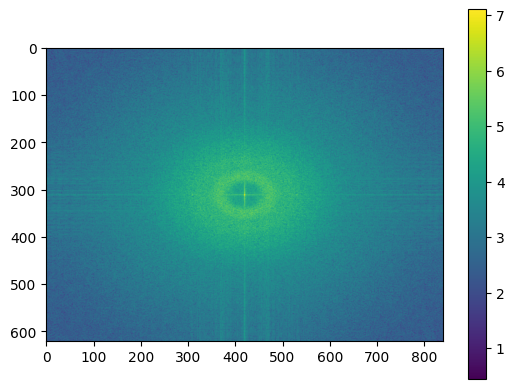

In [3]:
# load psf
datafolder = '../Calibration_Data'
# ACTION: choose psf file here
fname = 'psf_090_1.png'
# change the above two lines
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))
padded_psf = sdc.pad2d(psf)  # pad the psf
padded_psf = padded_psf[110:730,:] # make the same size as calibration data.
plt.figure()
plt.imshow(padded_psf)
plt.colorbar()
plt.show()
fft_psf = torch.fft.fftshift(torch.fft.fft2(padded_psf,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(fft_psf)))
plt.colorbar()
plt.show() 

# Create measurement

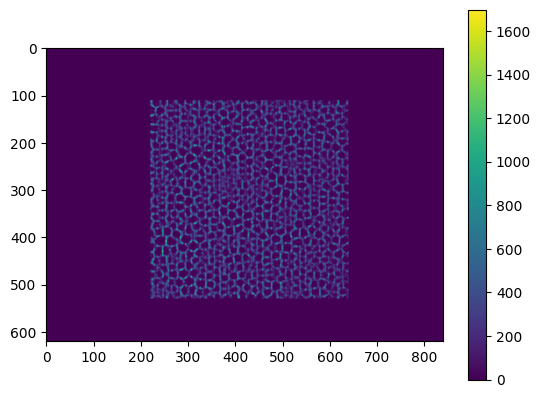

torch.Size([620, 840, 45])
320 430


In [ ]:
obj = torch.zeros_like(filter_array_normalized_tensor)
loc = [10,10] # y,x offset from center
obj[int(NY/2+loc[0]),int(NX/2+loc[1]),:] = 1.0 # point source in the center
padded_psf = sdc.pad2d(psf) 
padded_psf = sdc.pad2d(padded_psf)
resized_padded_psf = padded_psf[220:1460,:] # make the same size as filter array
resized_padded_psf_3d = sdc.make3d(resized_padded_psf,dim2) # permute along dim 2
fft_resized_padded_psf = sdc.fft3d(resized_padded_psf_3d) # take fft along dim 0 and 1
measurement = sdc.forwardmodel3d(sdc.pad3d(obj), fft_resized_padded_psf, filter_array_normalized_tensor)
measurement = measurement/torch.norm(measurement) 
plt.figure()
plt.imshow(measurement)
plt.colorbar() 
plt.show() 
print(obj.shape) 
print(int(NY/2+loc[0]),int(NX/2+loc[1])) 

## Now combine with gauss object

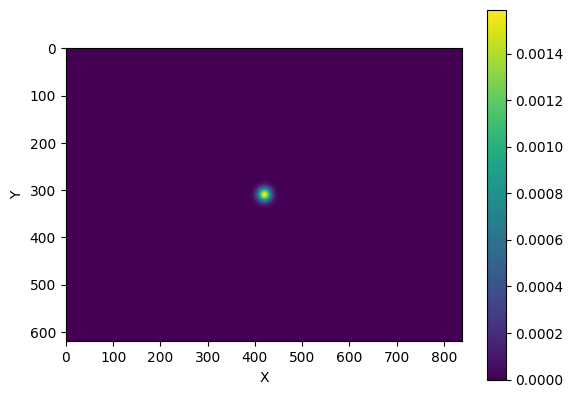

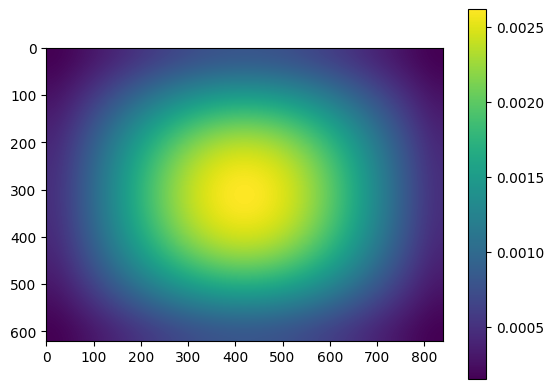

In [5]:
[x,y,coordinates] = gp.createMeshGrid(NX,NY)  
wavelengths = torch.arange(0,NL).float()
# g1 = gp.GaussObject(1.0,1.0,float(NL/2),100.0,100.0,float(NL*3),1.0) # make sure all are floating
gauss_object = gp.GaussObject(muy=0.0, mux=0.0, mul=float(NL/2), sigy=10.0, sigx=10.0, sigl=5.0, amp=1.0)
# gauss_object.plot(coordinates,NY,NX)

pdf_values = gauss_object.computeValues(coordinates, NY, NX)
plt.figure()
plt.imshow(pdf_values.detach().numpy())
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')


gauss_object_measurement = gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf, x,y,filter_array_normalized_tensor)
gauss_object_measurement = gauss_object_measurement/torch.norm(gauss_object_measurement) 
plt.figure()
plt.imshow(gauss_object_measurement.detach().numpy())
plt.colorbar() 
plt.show()

# learning

### learning for mux, muy only 

In [ ]:
# lr = [1e-2, 1e-2] # mux, muy
# # how to set the learning rate? 
# iterations = 100
# loss_GD = []

# # normalize the measurement
# for k2 in range(iterations):
#     # compute forward model
#     padded_psf_zeros = torch.zeros_like( gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor))
#     individual_measurements = padded_psf_zeros + gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor)  # compute individual measurements
#     computed_values = gauss_object.computeValues(coordinates, NY, NX)
#     individual_measurements = individual_measurements/torch.norm(individual_measurements)
    
#     # compute loss
#     loss = torch.norm(individual_measurements - measurement)
#     loss_GD.append(loss.item())
#     loss.backward()
    
#     if (k2 % 10 == 0):
#         print(loss.item())
        

#     # # print gradients
#     # print(gauss_object.covariancematrix.grad.data)
#     # print(gauss_object.mux.grad.data)
#     # print(gauss_object.muy.grad.data)
#     # # update gaussian parameters
#     gauss_object.gradStep()
#     gauss_object.zeroGrad()

# plt.figure()
# plt.plot(loss_GD)       
    

### Gaussian Localization

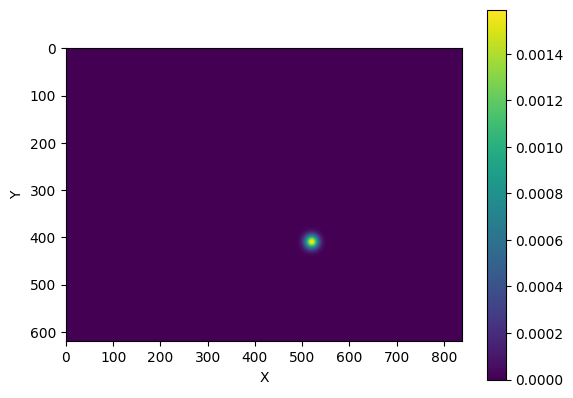

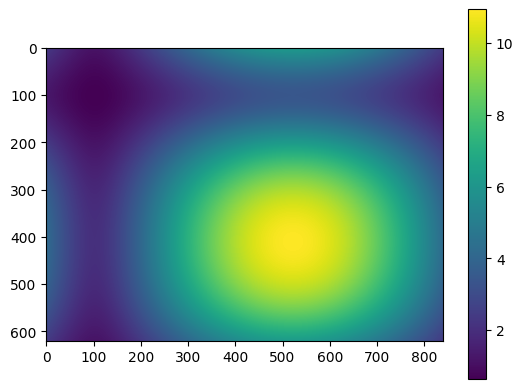

In [6]:
[x,y,coordinates] = gp.createMeshGrid(NX,NY)  
wavelengths = torch.arange(0,NL).float()
gauss_object_ground_truth = gp.GaussObject(muy=100.0, mux=100.0, mul=float(NL/2), sigy=10.0, sigx=10.0, sigl=5.0, amp=1.0)
pdf_values = gauss_object_ground_truth.computeValues(coordinates, NY, NX)
plt.figure()
plt.imshow(pdf_values.detach().numpy())
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

gauss_object_measurement = gp.forwardSingleGauss(gauss_object_ground_truth, coordinates, NX, NY, wavelengths, fft_psf, x,y,filter_array_normalized_tensor)
plt.figure()
plt.imshow(gauss_object_measurement.detach().numpy())
plt.colorbar()
plt.show()

In [7]:
iterations = 100
loss_GD = []

[x,y,coordinates] = gp.createMeshGrid(NX,NY)  
wavelengths = torch.arange(0,NL).float()
gauss_object_initial = gp.GaussObject(muy=5.0, mux=5.0, mul=float(NL/2), sigy=10.0, sigx=10.0, sigl=5.0, amp=1.0)


# normalize the measurement
for k in range(iterations):
    # compute forward model
    padded_psf_zeros = torch.zeros_like( gp.forwardSingleGauss(gauss_object_initial, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor))
    current_measurements = padded_psf_zeros + gp.forwardSingleGauss(gauss_object_initial, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor) 
    computed_values = gauss_object_initial.computeValues(coordinates, NY, NX)
    current_measurements = current_measurements/torch.norm(current_measurements)
    gauss_object_measurement = gauss_object_measurement / torch.norm(gauss_object_measurement)
    
    # compute loss
    loss = torch.norm(current_measurements - gauss_object_measurement)
    loss_GD.append(loss.item())
    loss.backward()
    
    
    if (k % 10 == 0):
        print(f"Iteration {k}, grad mux: {gauss_object_initial.mux.grad.item()}, grad muy: {gauss_object_initial.muy.grad.item()}")
        print(f"Iteration {k}, loss: {loss.item()}")
        print(f"Iteration {k}, muy: {gauss_object_initial.muy.item()}, mux: {gauss_object_initial.mux.item()}")
    
    
    # backpropagation
    gauss_object_initial.gradStep()
    gauss_object_initial.zeroGrad()

plt.figure()
plt.plot(loss_GD)       
    

Iteration 0, grad mux: -1.5393074750900269, grad muy: -1.2528753280639648
Iteration 0, loss: 0.4107699990272522
Iteration 0, muy: 5.0, mux: 5.0


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
plt.imshow(gauss_object_measurement.detach().numpy())

In [ ]:
plt.imshow(current_measurements.detach().numpy())

In [ ]:

# plt.imshow(current_measurements.detach().numpy() - gauss_object_measurement.detach().numpy())
current_measurements.detach().numpy() - gauss_object_measurement.detach().numpy()

In [ ]:
gauss_object_off = gp.GaussObject(muy=0.0, mux=1.0, mul=float(NL/2), sigy=1.0, sigx=1.0, sigl=5.0, amp=1.0)



gauss_object_off_measurement = gp.forwardSingleGauss(gauss_object_off, coordinates, NX, NY, wavelengths, fft_psf, x,y,filter_array_normalized_tensor)
plt.figure()
plt.imshow(gauss_object_off_measurement.detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
gauss_object_off = gp.GaussObject(muy=100.0, mux=100.0, mul=float(NL/2), sigy=1.0, sigx=1.0, sigl=5.0, amp=1.0)



gauss_object_off_measurement = gp.forwardSingleGauss(gauss_object_off, coordinates, NX, NY, wavelengths, fft_psf, x,y,filter_array_normalized_tensor)

plt.figure()
plt.imshow(gauss_object_off_measurement.detach().numpy())
plt.colorbar() 
plt.show() 

In [6]:
import torch.nn.functional as F

In [ ]:
iterations = 100
loss_GD = []
NY, NX, NL = filter_array_normalized_tensor.shape
high_NX = NX * 5
high_NY = NY * 5
[x,y,coordinates] = gp.createMeshGrid(high_NX,high_NY)  
wavelengths = torch.arange(0,NL).float()
gauss_object_initial = gp.GaussObject(muy=10.3, mux=10.4, mul=float(NL/2), sigy=1.0, sigx=1.0, sigl=5.0, amp=1.0)
Hfft = fft_psf
Hfft_real = Hfft.real
Hfft_imag = Hfft.imag
Hfft_real_refined = F.interpolate(
    Hfft_real.unsqueeze(0).unsqueeze(0),
    size=(high_NY, high_NX),
    mode='bilinear',
    align_corners=False
).squeeze(0).squeeze(0)

Hfft_imag_refined = F.interpolate(
    Hfft_imag.unsqueeze(0).unsqueeze(0),
    size=(high_NY, high_NX),
    mode='bilinear',
    align_corners=False
).squeeze(0).squeeze(0)

fft_psf_refined = torch.complex(Hfft_real_refined, Hfft_imag_refined)

measurement_resized = F.interpolate(
    measurement.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
    size=(high_NY, high_NX),  # Resize to high_NY, high_NX
    mode='bilinear',  # Use bilinear interpolation for resizing
    align_corners=False  # Don't align corners, this helps with subpixel accuracy
).squeeze(0).squeeze(0)

# normalize the measurement
for k in range(iterations):
    # compute forward model
    padded_psf_zeros = torch.zeros_like( gp.forwardSingleGauss(gauss_object_initial, coordinates, high_NX, high_NY, wavelengths, fft_psf_refined, x,y, filter_array_normalized_tensor))
    current_measurements = padded_psf_zeros + gp.forwardSingleGauss(gauss_object_initial, coordinates, high_NX, high_NY, wavelengths, fft_psf_refined, x,y, filter_array_normalized_tensor) 
    computed_values = gauss_object_initial.computeValues(coordinates,high_NX, high_NY)
    current_measurements = current_measurements / torch.norm(current_measurements)
    # compute loss
    loss = torch.norm(current_measurements - measurement_resized)
    loss_GD.append(loss.item())
    loss.backward()
    if (k % 10 == 0):
        print(f"Iteration {k}, grad mux: {gauss_object_initial.mux.grad.item()}, grad muy: {gauss_object_initial.muy.grad.item()}")
        print(f"Iteration {k}, loss: {loss.item()}")
        print(f"Iteration {k}, muy: {gauss_object_initial.muy.item()}, mux: {gauss_object_initial.mux.item()}")
    # backpropagation
    gauss_object_initial.gradStep()
    gauss_object_initial.zeroGrad()

plt.figure()
plt.plot(loss_GD)       

Iteration 0, grad mux: -4.332148551940918, grad muy: -34.39988708496094
Iteration 0, loss: 541422.5912238598
Iteration 0, muy: 10.300000190734863, mux: 10.399999618530273


KeyboardInterrupt: 